In [1]:
import torch
import torch_geometric
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import NormalizeFeatures
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=NormalizeFeatures())

data = dataset[0]


Processing...
Done!


In [4]:
import torch.nn.functional as F

In [5]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return torch.log_softmax(x, dim=1)


In [6]:
device = torch.device('cpu')
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = pred[data.test_mask] == data.y[data.test_mask]
    acc = int(correct.sum()) / int(data.test_mask.sum())
    return acc, pred

for epoch in range(200):
    train()

acc, pred = test()
print(f'Accuracy: {acc:.4f}')


Accuracy: 0.8190


In [8]:
pred

tensor([3, 4, 4,  ..., 1, 3, 3])

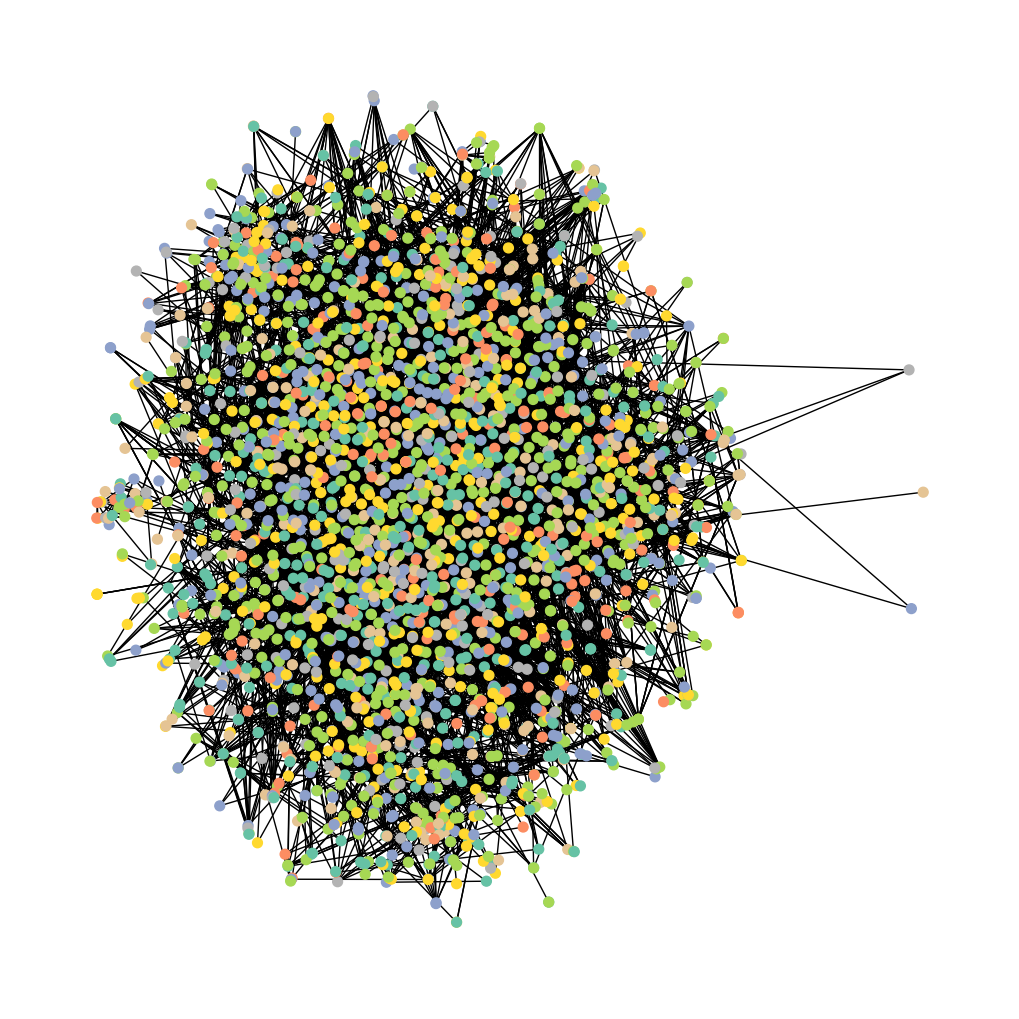

In [7]:
def plot_graph(pred):
    G = nx.Graph()

    edge_index = data.edge_index.cpu().numpy()
    for i in range(edge_index.shape[1]):
        G.add_edge(edge_index[0, i], edge_index[1, i])

    pos = TSNE(n_components=2).fit_transform(data.x.cpu().numpy())
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos=pos, node_color=pred.cpu().numpy(), cmap=plt.get_cmap("Set2"), node_size=50)
    plt.show()

plot_graph(pred)


In [9]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool

imdb_dataset = TUDataset(root='/tmp/IMDB-BINARY', name='IMDB-BINARY')
enzyme_dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')


Processing...
Done!
Processing...
Done!


In [15]:
def preprocess_dataset(dataset):
    for data in dataset:
        if data.x is None:
            data.x = torch.ones((data.num_nodes, 1), device=data.edge_index.device)
    return dataset

imdb_dataset = preprocess_dataset(imdb_dataset)
enzyme_dataset = preprocess_dataset(enzyme_dataset)

In [20]:
imdb_dataset

IMDB-BINARY(1000)

In [28]:
class GCNGraph(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCNGraph, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.conv2 = GCNConv(64, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, data):
        if data.x is None:
            data.x = torch.ones((data.num_nodes, 1), device=data.edge_index.device)

        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Aggregate graph-level features
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc(x)
        return torch.log_softmax(x, dim=1)


In [29]:
def train_graph_model(dataset, epochs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    num_node_features = dataset.num_features if dataset.num_features > 0 else 1

    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    model = GCNGraph(num_node_features, dataset.num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    for batch in loader:
        batch = batch.to(device)
        out = model(batch)
        pred = out.argmax(dim=1)
        correct += int((pred == batch.y).sum())

    accuracy = correct / len(dataset)
    return accuracy

imdb_acc = train_graph_model(imdb_dataset)
enzyme_acc = train_graph_model(enzyme_dataset)

print(f'IMDB-BINARY Accuracy: {imdb_acc:.4f}')
print(f'ENZYMES Accuracy: {enzyme_acc:.4f}')


IMDB-BINARY Accuracy: 0.6290
ENZYMES Accuracy: 0.3017


#### Interesting about reading
I found the fast approximation of convolutions on graphs interesting. How they got from equation 3 to equation 7/8. Going from direct spectral graph convolution to approximating them using Chebyshev's polynomials allowed for faster computation and having local convolution filters instead of graph wide filters.

#### Difficulty Understanding

I had difficulty understanding and visualizing some of the math, especially when it comes to why the approximations are valid, or even its necessary to go over direct spectra graph convolutions when the eigenvectors in the actual layers are lost as you doing spatial instead of spectral
